In [ ]:
# Run final DBSCAN clustering with optimal parameters
print("Running final DBSCAN clustering...")
print(f"Parameters: eps={final_eps:.6f}, min_samples={final_min_samples}")

# Create and fit DBSCAN model
final_dbscan = DBSCAN(eps=final_eps, min_samples=final_min_samples, n_jobs=-1)
dbscan_labels = final_dbscan.fit_predict(embeddings_gemma)

# Add cluster labels to dataframe
df_dbscan_clean["dbscan_cluster"] = dbscan_labels

# Analyze clustering results
n_clusters_final = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise_final = list(dbscan_labels).count(-1)
noise_ratio_final = n_noise_final / len(dbscan_labels)

print("\n✓ DBSCAN clustering completed!")
print("📊 Clustering Results:")
print(f"  • Total data points: {len(dbscan_labels):,}")
print(f"  • Number of clusters found: {n_clusters_final}")
print(f"  • Noise points (outliers): {n_noise_final:,} ({noise_ratio_final:.1%})")
print(
    f"  • Clustered points: {len(dbscan_labels) - n_noise_final:,} ({(1 - noise_ratio_final):.1%})"
)

# Calculate final silhouette score
if n_clusters_final > 1:
    non_noise_mask = dbscan_labels != -1
    if np.sum(non_noise_mask) > 1:
        final_silhouette = silhouette_score(
            embeddings_gemma[non_noise_mask], dbscan_labels[non_noise_mask]
        )
        print(f"  • Silhouette score: {final_silhouette:.3f}")
    else:
        print("  • Silhouette score: Cannot calculate (insufficient non-noise points)")
else:
    print("  • Silhouette score: Cannot calculate (insufficient clusters)")

# Show cluster distribution
print("\n📈 Cluster Distribution:")
cluster_counts = Counter(dbscan_labels)
for cluster_id in sorted(cluster_counts.keys()):
    if cluster_id == -1:
        print(f"  Noise (outliers): {cluster_counts[cluster_id]:,} points")
    else:
        print(f"  Cluster {cluster_id}: {cluster_counts[cluster_id]:,} points")

# Show largest and smallest clusters (excluding noise)
valid_clusters = {k: v for k, v in cluster_counts.items() if k != -1}
if valid_clusters:
    largest_cluster = max(valid_clusters, key=valid_clusters.get)
    smallest_cluster = min(valid_clusters, key=valid_clusters.get)
    print("\n  📏 Cluster sizes:")
    print(
        f"    Largest cluster {largest_cluster}: {valid_clusters[largest_cluster]:,} points"
    )
    print(
        f"    Smallest cluster {smallest_cluster}: {valid_clusters[smallest_cluster]:,} points"
    )
    print(
        f"    Average cluster size: {np.mean(list(valid_clusters.values())):.1f} points"
    )

### Run Final DBSCAN Clustering

In [ ]:
# Select optimal parameters based on criteria
print("Step 3: Selecting optimal parameters...")

# Filter results with reasonable characteristics
# - At least 5 clusters but not too many
# - Noise ratio between 5% and 30% (some noise is expected and healthy)
# - Positive silhouette score
filtered_results = results_df[
    (results_df["n_clusters"] >= 5)
    & (results_df["n_clusters"] <= 50)
    & (results_df["noise_ratio"] >= 0.05)
    & (results_df["noise_ratio"] <= 0.30)
    & (results_df["silhouette_score"] > 0)
]

if len(filtered_results) > 0:
    # Select best based on silhouette score
    best_idx = filtered_results["silhouette_score"].idxmax()
    best_params = results_df.loc[best_idx]

    print("✓ Optimal parameters found:")
    print(f"  eps: {best_params['eps']:.6f}")
    print(f"  min_samples: {best_params['min_samples']}")
    print(f"  Expected clusters: {best_params['n_clusters']}")
    print(f"  Expected noise ratio: {best_params['noise_ratio']:.1%}")
    print(f"  Silhouette score: {best_params['silhouette_score']:.3f}")

    final_eps = best_params["eps"]
    final_min_samples = int(best_params["min_samples"])
else:
    # Fallback to reasonable defaults
    print("⚠ No optimal parameters found in filtered results. Using fallback values...")
    final_eps = optimal_eps
    final_min_samples = 5
    print(f"  Using eps: {final_eps:.6f}")
    print(f"  Using min_samples: {final_min_samples}")

# Display parameter comparison visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Number of clusters vs eps for different min_samples
for min_samp in min_samples_values:
    subset = results_df[results_df["min_samples"] == min_samp]
    ax1.plot(subset["eps"], subset["n_clusters"], "o-", label=f"min_samples={min_samp}")
ax1.set_xlabel("eps")
ax1.set_ylabel("Number of Clusters")
ax1.set_title("Clusters vs eps")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Noise ratio vs eps
for min_samp in min_samples_values:
    subset = results_df[results_df["min_samples"] == min_samp]
    ax2.plot(
        subset["eps"], subset["noise_ratio"], "o-", label=f"min_samples={min_samp}"
    )
ax2.set_xlabel("eps")
ax2.set_ylabel("Noise Ratio")
ax2.set_title("Noise Ratio vs eps")
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Silhouette score vs eps
for min_samp in min_samples_values:
    subset = results_df[results_df["min_samples"] == min_samp]
    ax3.plot(
        subset["eps"], subset["silhouette_score"], "o-", label=f"min_samples={min_samp}"
    )
ax3.set_xlabel("eps")
ax3.set_ylabel("Silhouette Score")
ax3.set_title("Silhouette Score vs eps")
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: 2D parameter space heatmap of silhouette scores
pivot_data = results_df.pivot(
    index="min_samples", columns="eps", values="silhouette_score"
)
im = ax4.imshow(pivot_data, cmap="viridis", aspect="auto")
ax4.set_xticks(range(len(eps_values)))
ax4.set_xticklabels([f"{eps:.4f}" for eps in eps_values], rotation=45)
ax4.set_yticks(range(len(min_samples_values)))
ax4.set_yticklabels(min_samples_values)
ax4.set_xlabel("eps")
ax4.set_ylabel("min_samples")
ax4.set_title("Silhouette Score Heatmap")
plt.colorbar(im, ax=ax4)

plt.tight_layout()
plt.show()

In [ ]:
# Test different parameter combinations
print("Step 2: Testing different DBSCAN parameter combinations...")

# Define parameter ranges to test
eps_values = [
    optimal_eps * 0.7,
    optimal_eps * 0.85,
    optimal_eps,
    optimal_eps * 1.15,
    optimal_eps * 1.3,
]
min_samples_values = [3, 5, 7, 10]

print(f"Testing eps values: {[f'{eps:.6f}' for eps in eps_values]}")
print(f"Testing min_samples values: {min_samples_values}")

results = []

# Test parameter combinations
for eps in eps_values:
    for min_samples in min_samples_values:
        print(f"  Testing eps={eps:.6f}, min_samples={min_samples}...")

        # Run DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
        cluster_labels = dbscan.fit_predict(embeddings_gemma)

        # Calculate metrics
        n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
        n_noise = list(cluster_labels).count(-1)
        noise_ratio = n_noise / len(cluster_labels)

        # Calculate silhouette score if we have valid clusters
        try:
            if n_clusters > 1 and n_noise < len(cluster_labels):
                # For silhouette score, remove noise points
                non_noise_idx = cluster_labels != -1
                if np.sum(non_noise_idx) > 1:
                    sil_score = silhouette_score(
                        embeddings_gemma[non_noise_idx], cluster_labels[non_noise_idx]
                    )
                else:
                    sil_score = -1
            else:
                sil_score = -1
        except:
            sil_score = -1

        results.append(
            {
                "eps": eps,
                "min_samples": min_samples,
                "n_clusters": n_clusters,
                "n_noise": n_noise,
                "noise_ratio": noise_ratio,
                "silhouette_score": sil_score,
            }
        )

        print(
            f"    → Clusters: {n_clusters}, Noise: {n_noise} ({noise_ratio:.1%}), Silhouette: {sil_score:.3f}"
        )

# Convert results to DataFrame for easy analysis
import pandas as pd

results_df = pd.DataFrame(results)

print("\nParameter testing completed. Summary of results:")
print(results_df.round(4))

In [ ]:
# Import required libraries for DBSCAN
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors


# Function to estimate optimal eps using k-distance graph
def estimate_eps(X, min_samples=5, plot=True):
    """
    Estimate optimal eps parameter using k-distance graph method.
    The optimal eps is at the elbow/knee point of the k-distance plot.
    """
    print("Estimating optimal eps parameter...")

    # Calculate k-nearest neighbors distances
    neighbors = NearestNeighbors(n_neighbors=min_samples)
    neighbors.fit(X)
    distances, indices = neighbors.kneighbors(X)

    # Sort the distances to k-th nearest neighbor
    k_distances = np.sort(distances[:, min_samples - 1])[::-1]

    if plot:
        plt.figure(figsize=(10, 6))
        plt.plot(range(len(k_distances)), k_distances, "b-", linewidth=1)
        plt.xlabel("Data points sorted by distance")
        plt.ylabel(f"{min_samples}-th nearest neighbor distance")
        plt.title(f"K-distance Graph (k={min_samples})")
        plt.grid(True, alpha=0.3)

        # Try to find elbow point (simple heuristic)
        # Look for the point where the slope changes most dramatically
        if len(k_distances) > 100:
            # Calculate second derivative to find inflection point
            second_deriv = np.diff(k_distances, 2)
            elbow_idx = np.argmax(np.abs(second_deriv)) + 1
            suggested_eps = k_distances[elbow_idx]

            plt.axhline(
                y=suggested_eps,
                color="r",
                linestyle="--",
                label=f"Suggested eps: {suggested_eps:.4f}",
            )
            plt.axvline(x=elbow_idx, color="r", linestyle="--", alpha=0.7)

        plt.legend()
        plt.tight_layout()
        plt.show()

        # Return suggested eps value
        return (
            suggested_eps
            if len(k_distances) > 100
            else k_distances[len(k_distances) // 10]
        )

    return k_distances[len(k_distances) // 10]  # Simple heuristic


# Estimate optimal eps
print("Step 1: Estimating optimal eps parameter...")
optimal_eps = estimate_eps(embeddings_gemma, min_samples=5, plot=True)
print(f"Suggested eps value: {optimal_eps:.6f}")

### DBSCAN Parameter Optimization

DBSCAN has two key parameters:
- **eps (ε)**: The maximum distance between two samples for them to be considered neighbors
- **min_samples**: The minimum number of samples in a neighborhood for a point to be considered a core point

We'll experiment with different parameter combinations to find optimal clustering.

In [ ]:
# Generate embeddings using the Gemma model
print("Generating embeddings for combined text...")
print(f"Processing {len(df_dbscan_clean):,} text entries...")

# For large datasets, we might want to process in smaller batches
batch_size = 1000 if len(df_dbscan_clean) > 5000 else len(df_dbscan_clean)
print(f"Using batch size: {batch_size}")

try:
    # Generate embeddings with progress tracking
    embeddings_gemma = gemma_model.encode(
        df_dbscan_clean["combined_text"].tolist(),
        show_progress_bar=True,
        batch_size=batch_size,
        convert_to_tensor=False,  # Get numpy arrays for DBSCAN
        convert_to_numpy=True,
        normalize_embeddings=True,  # Normalize for better clustering performance
    )

    print("✓ Embeddings generated successfully!")
    print(f"Embeddings shape: {embeddings_gemma.shape}")
    print(f"Embedding dimension: {embeddings_gemma.shape[1]}")
    print(f"Data type: {embeddings_gemma.dtype}")

    # Check for any issues with embeddings
    print("\nEmbedding quality check:")
    print(f"- Contains NaN values: {np.isnan(embeddings_gemma).any()}")
    print(f"- Contains infinite values: {np.isinf(embeddings_gemma).any()}")
    print(f"- Min value: {embeddings_gemma.min():.6f}")
    print(f"- Max value: {embeddings_gemma.max():.6f}")
    print(f"- Mean norm: {np.linalg.norm(embeddings_gemma, axis=1).mean():.6f}")

except Exception as e:
    print(f"❌ Error generating embeddings: {e}")
    raise

### Generate Embeddings

In [ ]:
# Load the embedding-gemma-300m model
import torch
from sentence_transformers import SentenceTransformer

print("Loading embedding-gemma-300m model...")
try:
    # Load the Gemma embedding model
    gemma_model = SentenceTransformer("embedding-gemma-300m")
    print("✓ Gemma embedding model loaded successfully!")

    # Show model information
    print(f"Model max sequence length: {gemma_model.max_seq_length}")
    print(f"Model device: {gemma_model.device}")

    # Set proper tensor type for compatibility
    torch.set_default_dtype(torch.float32)

except Exception as e:
    print(f"❌ Error loading Gemma model: {e}")
    print("Falling back to all-MiniLM-L6-v2...")
    gemma_model = SentenceTransformer("all-MiniLM-L6-v2")
    print("✓ Fallback model loaded successfully!")

### Load Gemma Embedding Model

In [ ]:
# Create combined text from consumable_name and consumable_ingredients
print("Preparing text data for embedding...")

df_dbscan["combined_text"] = (
    df_dbscan["consumable_name"].fillna("")
    + " | Ingredients: "
    + df_dbscan["consumable_ingredients"].fillna("")
)
df_dbscan["combined_text"] = df_dbscan["combined_text"].str.strip()

# Remove empty entries
df_dbscan_clean = df_dbscan[df_dbscan["combined_text"].str.len() > 0].copy()
print(f"Original dataset size: {len(df_dbscan):,}")
print(f"After removing empty text: {len(df_dbscan_clean):,}")

# Show sample combined text
print("\nSample combined text entries:")
for i, text in enumerate(df_dbscan_clean["combined_text"].head(5)):
    print(f"{i + 1}. {text[:100]}{'...' if len(text) > 100 else ''}")

# Check for any potential data quality issues
print("\nData quality check:")
print(
    f"- Records with missing consumable_name: {df_dbscan_clean['consumable_name'].isna().sum():,}"
)
print(
    f"- Records with missing ingredients: {df_dbscan_clean['consumable_ingredients'].isna().sum():,}"
)
print(
    f"- Average text length: {df_dbscan_clean['combined_text'].str.len().mean():.1f} characters"
)

### Prepare Text Data for Embedding

In [ ]:
# Import the get_table function from database utils
import os
import sys

from dotenv import load_dotenv

load_dotenv()
project_root = os.getenv("root_folder")
if project_root:
    sys.path.append(project_root)

from database.utils.db_utils import get_table

# Load fresh data from the consumable table
print("Loading data from consumable table...")
df_dbscan = get_table("consumable")
print(f"Loaded {len(df_dbscan):,} records from consumable table")
print(f"Available columns: {list(df_dbscan.columns)}")

# Display basic info about the dataset
print(f"\nDataset shape: {df_dbscan.shape}")
print("Consumable types distribution:")
print(df_dbscan["consumable_type"].value_counts())

### Load Data Using Database Function

## DBSCAN Clustering with Gemma Embeddings

This section implements DBSCAN clustering using the Gemma embedding model instead of K-means. DBSCAN is particularly well-suited for food clustering because:

1. **Density-based clustering**: Finds clusters of varying shapes and sizes
2. **Automatic outlier detection**: Identifies unusual dishes as noise points (label -1)
3. **No need to specify number of clusters**: Algorithm determines this automatically
4. **Robust to irregular cluster shapes**: Better than K-means for complex data distributions

We'll use the `embedding-gemma-300m` model which provides more nuanced embeddings for food-related text.

## Clear Consumable Table

# Explore unique entries in dataframe

## Imports

In [3]:
import os

import numpy as np
import pandas as pd

## Read Data

In [ ]:
# Read data from database
import os
import sys

from dotenv import load_dotenv

load_dotenv()
project_root = os.getenv("root_folder")
if project_root:
    sys.path.append(project_root)

from database.utils.db_utils import get_table

df_unique = get_table("consumable")
print(f"Loaded {len(df_unique):,} records from database")
print(f"Available columns: {list(df_unique.columns)}")

In [5]:
df_unique["consumable_type"].value_counts()

consumable_type
Homemade food                9452
Restaurant food              6504
Packaged food                2634
Raw vegetables and fruits     612
Others                         85
Name: count, dtype: int64

In [6]:
df_unique.columns

Index(['id', 'image_url', 'consumable_name', 'consumable_type',
       'consumable_ingredients', 'consumable_portion_size',
       'consumable_nutritional_profile', 'consumable_cooking_method',
       'created_at'],
      dtype='object')

## Mini Batch K-Means Clustering for Cuisine Identification

In [7]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

/Users/luvsuneja/Documents/repos/masala-embed/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm

A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/luvsuneja/Documents/repos/masala-embed/.venv/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
   

In [8]:
# Create combined text from consumable_name and consumable_ingredients
df_unique["combined_text"] = (
    df_unique["consumable_name"].fillna("")
    + " \nIngredients:"
    + df_unique["consumable_ingredients"].fillna("")
)
df_unique["combined_text"] = df_unique["combined_text"].str.strip()

# Remove empty entries
df_clean = df_unique[df_unique["combined_text"] != ""].copy()
print(f"Original dataset size: {len(df_unique)}")
print(f"Cleaned dataset size: {len(df_clean)}")
print("Sample combined text:")
print(df_clean["combined_text"].head())

Original dataset size: 19287
Cleaned dataset size: 19287
Sample combined text:
0    Pho \nIngredients:["noodles","beef","basil","l...
1    Pan-fried Dumplings \nIngredients:["dumplings"...
2                    Bananas \nIngredients:["Bananas"]
3    Noodle Stir-Fry \nIngredients:["noodles","chic...
4    Shrimp and Noodle Appetizer \nIngredients:["sh...
Name: combined_text, dtype: object


In [9]:
# Load the all-MiniLM-L6-v2 model
print("Loading sentence transformer model...")
model = SentenceTransformer("all-MiniLM-L6-v2")
print("Model loaded successfully!")

Loading sentence transformer model...
Model loaded successfully!


In [10]:
import torch

torch.set_default_tensor_type("torch.FloatTensor")

/Users/luvsuneja/Documents/repos/masala-embed/.venv/lib/python3.12/site-packages/torch/__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


In [11]:
# Generate embeddings for combined text (keep as tensors)
print("Generating embeddings...")

# Get embeddings as tensors and keep them as tensors
embeddings = model.encode(
    df_clean["combined_text"].tolist(),
    show_progress_bar=True,
    convert_to_tensor=True,
    convert_to_numpy=False,
)

print(f"Embeddings shape: {embeddings.shape}")
print(f"Embedding dimension: {embeddings.shape[1]}")
print(f"Embeddings type: {type(embeddings)}")
print(f"Device: {embeddings.device}")

Generating embeddings...


Batches: 100%|██████████| 603/603 [00:25<00:00, 23.59it/s]


Embeddings shape: torch.Size([19287, 384])
Embedding dimension: 384
Embeddings type: <class 'torch.Tensor'>
Device: mps:0


Finding optimal number of clusters...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/Users/luvsuneja/Documents/repos/masala-embed/.venv/lib/python3.12/site-packages/threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


k=5: inertia=9418.72, silhouette=0.040
k=6: inertia=9279.81, silhouette=0.038
k=7: inertia=9087.00, silhouette=0.043
k=8: inertia=9003.86, silhouette=0.043
k=9: inertia=8923.58, silhouette=0.042
k=10: inertia=8807.58, silhouette=0.043
k=11: inertia=8585.30, silhouette=0.053
k=12: inertia=8545.26, silhouette=0.052
k=13: inertia=8484.94, silhouette=0.050
k=14: inertia=8411.62, silhouette=0.053
k=15: inertia=8259.22, silhouette=0.056
k=16: inertia=8196.19, silhouette=0.057
k=17: inertia=8169.64, silhouette=0.057
k=18: inertia=8135.19, silhouette=0.056
k=19: inertia=8107.98, silhouette=0.055
k=20: inertia=8084.97, silhouette=0.054


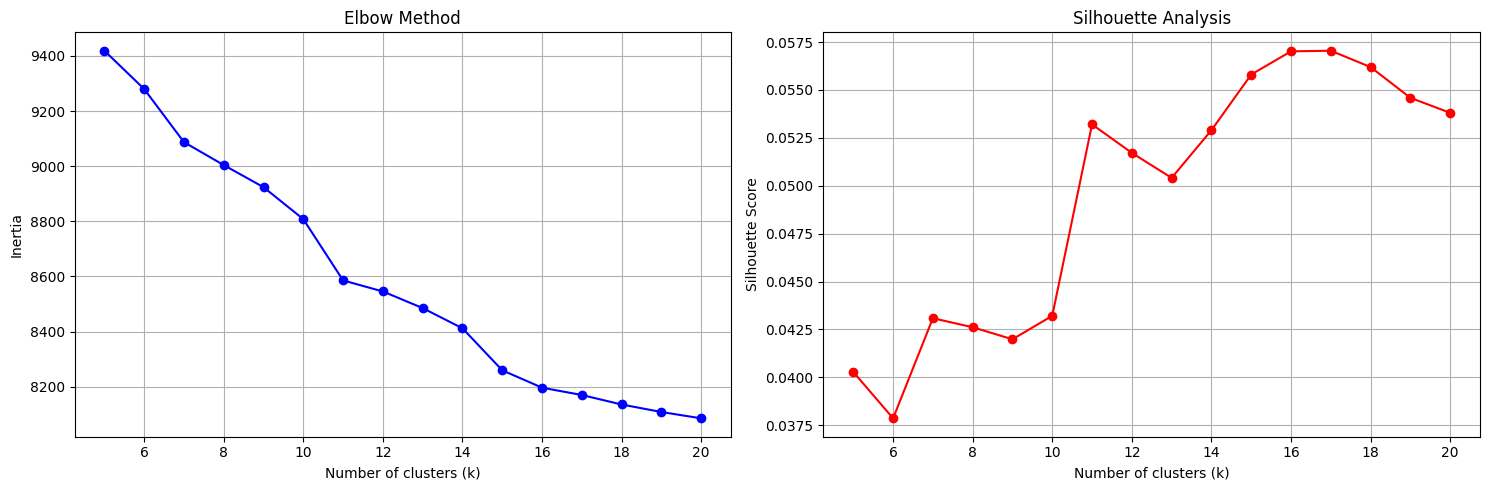


Optimal number of clusters based on silhouette score: 17


In [12]:
# Determine optimal number of clusters using elbow method (tensor version)
import torch

# Convert tensor to list for sklearn (workaround)
embeddings_list = embeddings.tolist()

k_range = range(5, 21)  # Test 5 to 20 clusters
inertias = []
silhouette_scores = []

print("Finding optimal number of clusters...")
for k in k_range:
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=1000)
    cluster_labels = kmeans.fit_predict(embeddings_list)

    inertias.append(kmeans.inertia_)
    sil_score = silhouette_score(embeddings_list, cluster_labels)
    silhouette_scores.append(sil_score)

    print(f"k={k}: inertia={kmeans.inertia_:.2f}, silhouette={sil_score:.3f}")

# Plot elbow curve and silhouette scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(k_range, inertias, "bo-")
ax1.set_xlabel("Number of clusters (k)")
ax1.set_ylabel("Inertia")
ax1.set_title("Elbow Method")
ax1.grid(True)

ax2.plot(k_range, silhouette_scores, "ro-")
ax2.set_xlabel("Number of clusters (k)")
ax2.set_ylabel("Silhouette Score")
ax2.set_title("Silhouette Analysis")
ax2.grid(True)

plt.tight_layout()
plt.show()

# Find optimal k based on silhouette score
optimal_k = k_range[
    max(range(len(silhouette_scores)), key=silhouette_scores.__getitem__)
]
print(f"\nOptimal number of clusters based on silhouette score: {optimal_k}")

In [13]:
# Perform final clustering with optimal k (tensor version)
print(f"Performing MiniBatchKMeans clustering with k={optimal_k}...")
final_kmeans = MiniBatchKMeans(n_clusters=optimal_k, random_state=42, batch_size=1000)
cluster_labels = final_kmeans.fit_predict(embeddings_list)

# Add cluster labels to dataframe
df_clean["cuisine_cluster"] = cluster_labels

print("Clustering completed!")
print("Cluster distribution:")
cluster_counts = Counter(cluster_labels)
for cluster_id, count in sorted(cluster_counts.items()):
    print(f"Cluster {cluster_id}: {count} dishes")

Performing MiniBatchKMeans clustering with k=17...
Clustering completed!
Cluster distribution:
Cluster 0: 839 dishes
Cluster 1: 1261 dishes
Cluster 2: 343 dishes
Cluster 3: 1449 dishes
Cluster 4: 1472 dishes
Cluster 5: 868 dishes
Cluster 6: 1104 dishes
Cluster 7: 1308 dishes
Cluster 8: 1585 dishes
Cluster 9: 1459 dishes
Cluster 10: 1167 dishes
Cluster 11: 815 dishes
Cluster 12: 659 dishes
Cluster 13: 395 dishes
Cluster 14: 1401 dishes
Cluster 15: 1876 dishes
Cluster 16: 1286 dishes


In [14]:
# Analyze clusters by examining representative dishes
print("Analyzing clusters by examining representative dishes from each cluster:")
print("=" * 80)

for cluster_id in range(optimal_k):
    cluster_data = df_clean[df_clean["cuisine_cluster"] == cluster_id]
    print(f"\nCluster {cluster_id} ({len(cluster_data)} dishes):")
    print("-" * 40)

    # Show most common food types in this cluster
    food_type_dist = cluster_data["consumable_type"].value_counts()
    print(f"Food types: {dict(food_type_dist.head(3))}")

    # Show sample dishes from this cluster
    print("Sample dishes:")
    sample_dishes = cluster_data[["consumable_name", "consumable_ingredients"]].head(5)
    for idx, row in sample_dishes.iterrows():
        dish_name = (
            row["consumable_name"] if pd.notna(row["consumable_name"]) else "Unknown"
        )
        ingredients = (
            row["consumable_ingredients"]
            if pd.notna(row["consumable_ingredients"])
            else "Unknown"
        )
        print(
            f"  • {dish_name} | Ingredients: {ingredients[:100]}{'...' if len(str(ingredients)) > 100 else ''}"
        )

Analyzing clusters by examining representative dishes from each cluster:

Cluster 0 (839 dishes):
----------------------------------------
Food types: {'Homemade food': np.int64(637), 'Restaurant food': np.int64(175), 'Packaged food': np.int64(20)}
Sample dishes:
  • Scrambled Eggs with Bread | Ingredients: ["eggs","tomatoes","onions","bread"]
  • Breakfast Plate | Ingredients: ["corn","eggs","blueberries"]
  • Breakfast Sandwich | Ingredients: ["bread","cheese","egg","sausage"]
  • Fried Eggs with Toast | Ingredients: ["eggs","bread","olive oil","seasoning"]
  • Boiled Eggs | Ingredients: ["eggs","soy sauce","spices"]

Cluster 1 (1261 dishes):
----------------------------------------
Food types: {'Homemade food': np.int64(792), 'Restaurant food': np.int64(260), 'Raw vegetables and fruits': np.int64(121)}
Sample dishes:
  • Vegetable Fritters | Ingredients: ["vegetables","batter","spices"]
  • Mixed Asian Salad | Ingredients: ["cabbage","carrots","peanuts","cucumbers","chili","herbs"]


Creating visualizations...
Running t-SNE on 3000 samples...


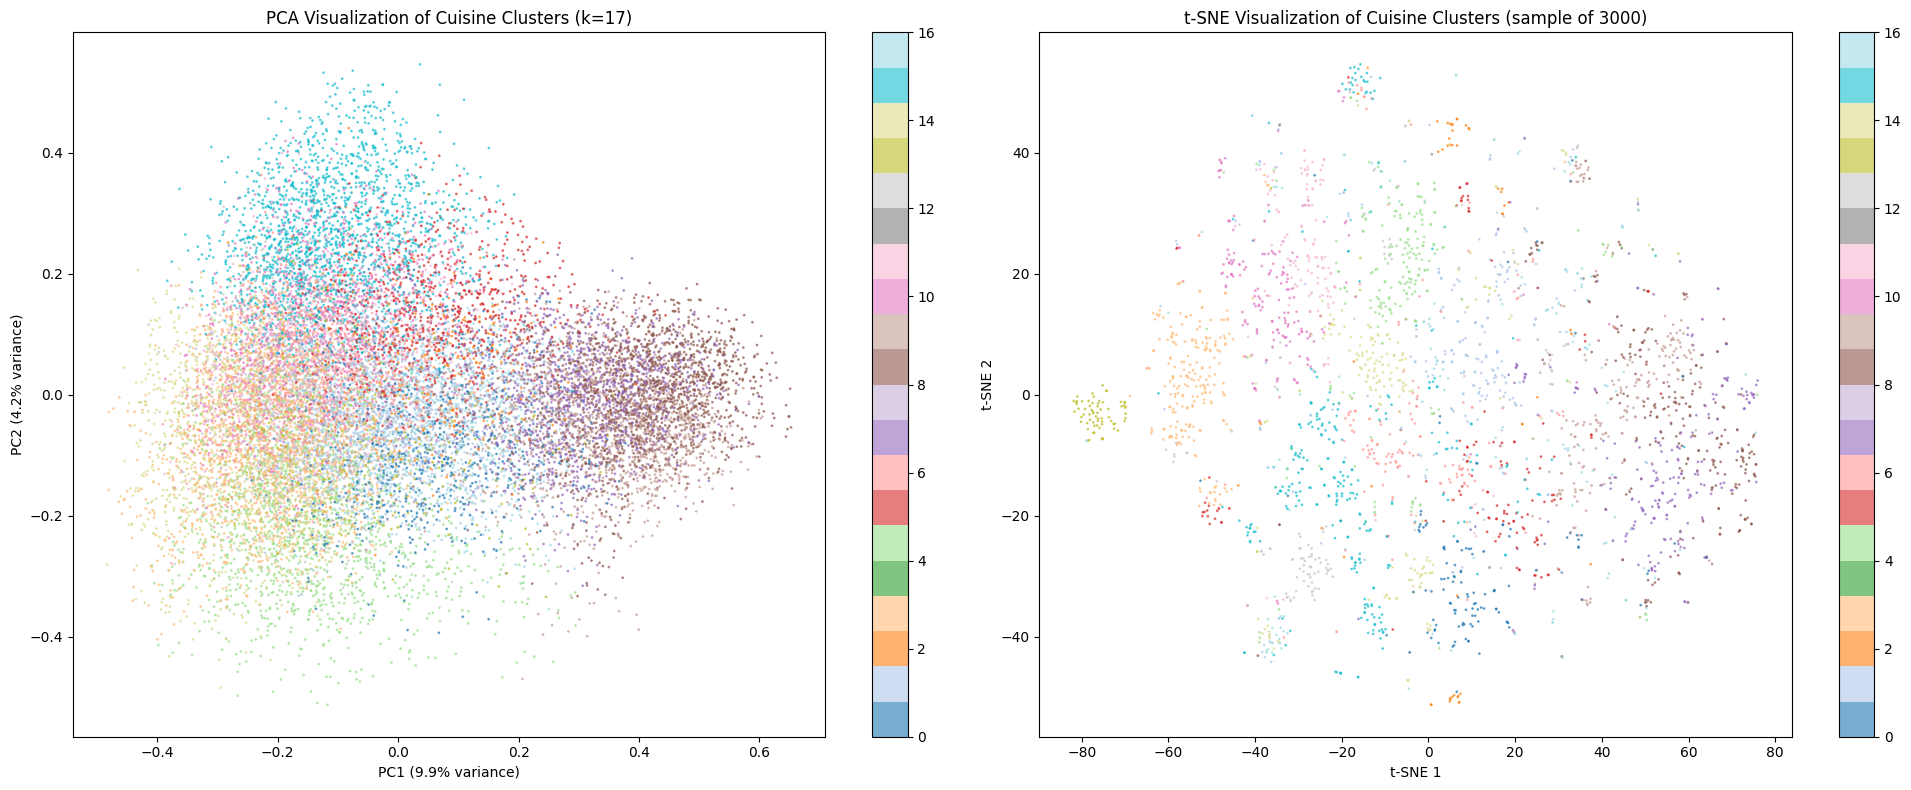

In [17]:
# Visualize clusters using PCA and t-SNE (proper numpy conversion)
print("Creating visualizations...")


# Convert to numpy array format - create our own simple array class
class SimpleArray:
    def __init__(self, data):
        self.data = data
        self.shape = (len(data), len(data[0]) if data else 0)

    def __getitem__(self, key):
        return self.data[key]

    def __len__(self):
        return len(self.data)


# PCA visualization
pca = PCA(n_components=2, random_state=42)
embeddings_pca = pca.fit_transform(embeddings_list)

# t-SNE visualization (on a subset for performance)
sample_size = min(3000, len(embeddings_list))
sample_indices = list(
    range(0, len(embeddings_list), max(1, len(embeddings_list) // sample_size))
)[:sample_size]
embeddings_sample = [embeddings_list[i] for i in sample_indices]
labels_sample = [cluster_labels[i] for i in sample_indices]

print(f"Running t-SNE on {len(embeddings_sample)} samples...")

# Convert to proper numpy-like array
try:
    # Try creating a simple 2D list that sklearn can handle
    import numpy as np

    embeddings_array = np.array(embeddings_sample)
except:
    # Fallback: create array-like structure
    embeddings_array = SimpleArray(
        [[float(x) for x in row] for row in embeddings_sample]
    )

tsne = TSNE(
    n_components=2, random_state=42, perplexity=min(30, len(embeddings_sample) // 4)
)
embeddings_tsne = tsne.fit_transform(embeddings_array)

# Create visualizations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# PCA plot
scatter1 = ax1.scatter(
    [row[0] for row in embeddings_pca],
    [row[1] for row in embeddings_pca],
    c=cluster_labels,
    cmap="tab20",
    alpha=0.6,
    s=1,
)
ax1.set_title(f"PCA Visualization of Cuisine Clusters (k={optimal_k})")
ax1.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)")
ax1.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)")
plt.colorbar(scatter1, ax=ax1)

# t-SNE plot
scatter2 = ax2.scatter(
    [row[0] for row in embeddings_tsne],
    [row[1] for row in embeddings_tsne],
    c=labels_sample,
    cmap="tab20",
    alpha=0.6,
    s=1,
)
ax2.set_title(
    f"t-SNE Visualization of Cuisine Clusters (sample of {len(labels_sample)})"
)
ax2.set_xlabel("t-SNE 1")
ax2.set_ylabel("t-SNE 2")
plt.colorbar(scatter2, ax=ax2)

plt.tight_layout()
plt.show()

In [18]:
df_clean.query("cuisine_cluster == 12").sample(5)

,id,image_url,consumable_name,consumable_type,consumable_ingredients,consumable_portion_size,consumable_nutritional_profile,consumable_cooking_method,created_at,combined_text,cuisine_cluster
826,826,https://file.b18a.io/7838729653800108585_67126...,Hearty Soup with Salad and Wrap,Restaurant food,"[""pork"",""vegetables"",""noodles"",""salad greens"",...","[""soup:400g"",""salad:150g"",""wrap:200g""]","{'fat_g': 30.0, 'protein_g': 40.0, 'calories_k...",boiled and stir-fried,2025-09-18 12:53:03.580313+00:00,Hearty Soup with Salad and Wrap \nIngredients:...,12
1593,1594,https://file.b18a.io/7839244205700102029_11728...,Fish Soup,Homemade food,"[""fish"",""broth"",""green onions""]","[""fish:200g"",""broth:300g""]","{'fat_g': 10.0, 'protein_g': 15.0, 'calories_k...",boiling,2025-09-18 12:53:03.580313+00:00,"Fish Soup \nIngredients:[""fish"",""broth"",""green...",12
2590,2591,https://file.b18a.io/7833144257400108044_23803...,Mixed Seafood and Meat Soup,Homemade food,"[""shrimp"",""tofu"",""pork"",""noodles"",""broth""]","[""shrimp:150g"",""tofu:100g"",""meat:100g"",""noodle...","{'fat_g': 25.0, 'protein_g': 35.0, 'calories_k...",boiled,2025-09-18 12:53:03.580313+00:00,"Mixed Seafood and Meat Soup \nIngredients:[""sh...",12
5002,5003,https://file.b18a.io/7841601440400102200_40803...,Beef Tripe Soup,Restaurant food,"[""beef tripe"",""broth"",""cilantro"",""green onions...","[""beef tripe:200g"",""broth:300g"",""herbs:50g""]","{'fat_g': 10.0, 'protein_g': 20.0, 'calories_k...",boiled,2025-09-18 12:53:03.580313+00:00,"Beef Tripe Soup \nIngredients:[""beef tripe"",""b...",12
8157,8154,https://file.b18a.io/7832680019100104758_26008...,Lotus Soup,Homemade food,"[""lotus root"",""goji berries"",""water""]","[""lotus root:200g"",""goji berries:10g""]","{'fat_g': 2.0, 'protein_g': 3.0, 'calories_kca...",boiling,2025-09-18 12:53:03.580313+00:00,"Lotus Soup \nIngredients:[""lotus root"",""goji b...",12


In [ ]:
# Save the results
print("Saving results...")

# Save the dataframe with cluster labels
output_path = os.path.join(data_folder, "mm-food-100k-unique-dishes-clustered.parquet")
df_clean.to_parquet(output_path, index=False)
print(f"Clustered dataset saved to: {output_path}")

# Save cluster analysis summary
summary_data = []
for cluster_id in range(optimal_k):
    cluster_data = df_clean[df_clean["cuisine_cluster"] == cluster_id]
    food_type_dist = cluster_data["consumable_type"].value_counts()

    summary_data.append(
        {
            "cluster_id": cluster_id,
            "size": len(cluster_data),
            "top_food_type": food_type_dist.index[0]
            if len(food_type_dist) > 0
            else "Unknown",
            "top_food_type_count": food_type_dist.iloc[0]
            if len(food_type_dist) > 0
            else 0,
            "sample_dishes": "; ".join(
                cluster_data["consumable_name"].dropna().head(3).tolist()
            ),
        }
    )

summary_df = pd.DataFrame(summary_data)
summary_path = os.path.join(data_folder, "cuisine_clusters_summary.csv")
summary_df.to_csv(summary_path, index=False)
print(f"Cluster summary saved to: {summary_path}")

print("\nCluster Summary:")
print(summary_df)

## Add Non-Vegetarian Flag to Dataset

In [ ]:
import os
import sys

from dotenv import load_dotenv

load_dotenv()
project_root = os.getenv("root_folder")
if project_root:
    sys.path.append(os.path.join(project_root, "esci-dataset", "src"))

from evals.dietary_evals import evaluate_dietary_flags, print_dietary_stats
# reload to ensure latest changes are picked up

In [20]:
# Apply all dietary flags to the dataset
df_clean = evaluate_dietary_flags(df_clean)

# Print comprehensive dietary statistics
print_dietary_stats(df_clean)

Dietary Analysis for 19,287 items:
Non-veg: 9,572 (49.6%)
Contains egg: 2,678 (13.9%)
Contains milk: 3,517 (18.2%)
Contains honey: 77 (0.4%)
Contains gluten: 4,523 (23.5%)
Contains nuts: 904 (4.7%)
Vegetarian (no non-veg): 9,715 (50.4%)
Vegan (no animal products): 5,954 (30.9%)
Lacto Veg: 2,336 (12.1%)
Gluten-free: 14,764 (76.5%)
Nut-free: 18,383 (95.3%)
Pescetarian-friendly (seafood only): 2,206 (11.4%)


In [21]:
df_clean["has_nuts"].sum()

np.int64(904)

In [22]:
df_clean["has_gluten"]

0         True
1        False
2        False
3         True
4         True
         ...  
19282     True
19283    False
19284    False
19285    False
19286    False
Name: has_gluten, Length: 19287, dtype: bool

In [23]:
df_clean[df_clean["has_honey"]][["consumable_name", "consumable_ingredients"]].sample(5)

,consumable_name,consumable_ingredients
14016,Manuka Honey,"[""Manuka honey""]"
16032,Honey Butter Flavored Fries,"[""potatoes"",""honey"",""butter"",""seasoning""]"
11365,Honey Garlic Chicken,"[""chicken"",""garlic"",""honey"",""soy sauce"",""ginger""]"
18330,Nut and Seed Snack Bar,"[""nuts"",""seeds"",""raisins"",""honey"",""crackers""]"
15063,Avocado Smoothie,"[""avocado"",""milk"",""honey""]"


In [ ]:
df_clean.head()

,image_url,camera_or_phone_prob,food_prob,dish_name,food_type,ingredients,portion_size,nutritional_profile,cooking_method,sub_dt,combined_text,cuisine_cluster,is_non_veg
0,https://file.b18a.io/7843322356500104680_44354...,0.7,0.95,Fried Chicken,Restaurant food,"[""chicken"",""breading"",""oil""]","[""chicken:300g""]","{""fat_g"":25.0,""protein_g"":30.0,""calories_kcal""...",Frying,20250704,"Fried Chicken \nIngredients:[""chicken"",""breadi...",18,True
1,https://file.b18a.io/7833227147700100732_67487...,0.7,1.00,Pho,Restaurant food,"[""noodles"",""beef"",""basil"",""lime"",""green onions...","[""noodles:200g"",""beef:100g"",""vegetables:50g""]","{""fat_g"":15.0,""protein_g"":25.0,""calories_kcal""...",boiled,20250702,"Pho \nIngredients:[""noodles"",""beef"",""basil"",""l...",15,True
2,https://file.b18a.io/7832600581600103585_26423...,0.8,0.95,Pan-fried Dumplings,Restaurant food,"[""dumplings"",""chili oil"",""soy sauce""]","[""dumplings:300g"",""sauce:50g""]","{""fat_g"":15.0,""protein_g"":20.0,""calories_kcal""...",Pan-frying,20250625,"Pan-fried Dumplings \nIngredients:[""dumplings""...",2,False
3,https://file.b18a.io/7839056601700101188_98515...,0.7,1.00,Bananas,Raw vegetables and fruits,"[""Bananas""]","[""Bananas: 10 pieces (about 1kg)""]","{""fat_g"":3.0,""protein_g"":12.0,""calories_kcal"":...",Raw,20250718,"Bananas \nIngredients:[""Bananas""]",8,False
4,https://file.b18a.io/7837642737500100261_17312...,0.8,0.90,Noodle Stir-Fry,Restaurant food,"[""noodles"",""chicken"",""vegetables"",""sauce""]","[""noodles:300g"",""chicken:100g"",""vegetables:50g""]","{""fat_g"":20.0,""protein_g"":25.0,""calories_kcal""...",stir-fried,20250711,"Noodle Stir-Fry \nIngredients:[""noodles"",""chic...",10,True


In [25]:
# Save updated dataset
data_folder = "../data"
df_clean.to_parquet(
    os.path.join(data_folder, "mm-food-100k-unique-dishes.parquet"), index=False
)
print("Dataset saved with dietary flags")

Dataset saved with dietary flags


In [30]:
from IPython.display import Markdown

md_table = (
    df_clean[["id", "consumable_name", "consumable_ingredients"]]
    .sample(10)
    .to_markdown(index=False)
)

# Display the Markdown table
display(Markdown(md_table))

|    id | consumable_name                   | consumable_ingredients                                                                  |
|------:|:----------------------------------|:----------------------------------------------------------------------------------------|
|  8147 | Coffee Milk Candy                 | ["coffee","sugar","milk"]                                                               |
|  3415 | Fruit Punch                       | ["berries","lemon","syrup","ice"]                                                       |
| 13361 | Assorted Meat Dishes              | ["beef","pork","seasoning","vegetables"]                                                |
|  7558 | Boiled Crab                       | ["crab"]                                                                                |
|   862 | Mixed Vegetable and Fruit Platter | ["lettuce","pumpkin","dragon fruit","melon","okra","meatballs"]                         |
| 16805 | Fried Bread and Drink             | ["bread","oil","sugar","water"]                                                         |
| 17253 | Vegetable Bibimbap                | ["cucumber","carrot","bean sprouts","egg","black bean sauce","lettuce","green noodles"] |
|  7119 | Fried Zucchini                    | ["zucchini","flour","egg","oil"]                                                        |
| 18913 | Noodles with Tofu and Soup        | ["noodles","tofu","soup","green onions"]                                                |
| 13923 | Seared Fish with Puree            | ["fish","puree","garnish"]                                                              |